# Rolling Forecast ARIMA Model

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Libraries
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import pyplot
from pandas.plotting import lag_plot
import numpy as np
%matplotlib inline
from pandas import DataFrame
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [4]:
stock_ticker = 'AMZN'

In [17]:
# Load the Amazon closing prices data
ticker_df = yf.download(stock_ticker, start="2011-01-01", end="2021-05-31")
ticker_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,181.369995,186.000000,181.210007,184.220001,184.220001,5331400
2011-01-04,186.149994,187.699997,183.779999,185.009995,185.009995,5031800
2011-01-05,184.100006,187.449997,184.070007,187.419998,187.419998,3418800
2011-01-06,186.500000,187.410004,185.250000,185.860001,185.860001,3179700
2011-01-07,187.880005,188.449997,183.740005,185.490005,185.490005,5221700
...,...,...,...,...,...,...
2021-05-24,3215.500000,3257.949951,3210.500000,3244.989990,3244.989990,2422800
2021-05-25,3266.669922,3279.820068,3213.760010,3259.050049,3259.050049,3261100
2021-05-26,3274.590088,3295.729980,3258.510010,3265.159912,3265.159912,2384000


In [58]:
ticker_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [87]:
ticker_df.dropna(inplace=True)

In [88]:
ticker_df.to_csv('Resources/amzn_closing_prices.csv')

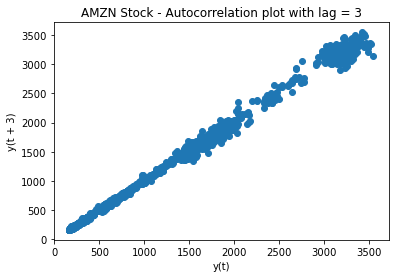

In [89]:
plt.figure()
lag_plot(ticker_df['Open'], lag=3)
plt.title('AMZN Stock - Autocorrelation plot with lag = 3')
plt.show()

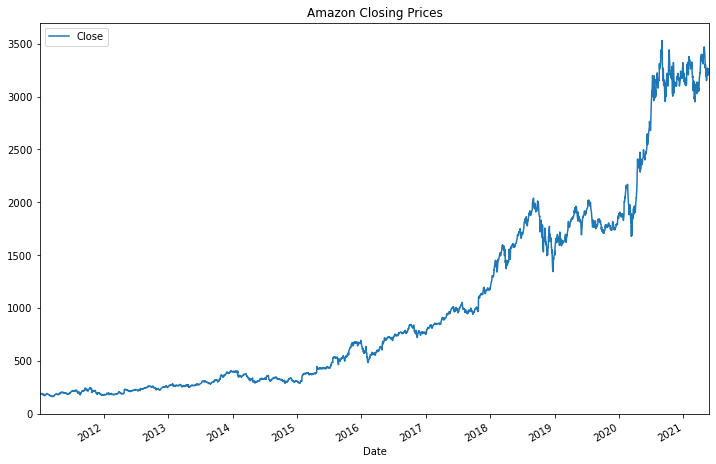

In [90]:
# Plot just the "Close" column from the dataframe:
ticker_df['Close'].plot(
    title='Amazon Closing Prices', 
    legend='Close', 
    figsize=(12, 8))
plt.margins(x=0)

In [91]:
# Apply the Augmented Dickey-Fuller test to determine if the above is stationary
from statsmodels.tsa.stattools import adfuller
adfuller(ticker_df.Close)

(1.8289930627889859,
 0.9984048195271049,
 27,
 2591,
 {'1%': -3.4328763567780456,
  '5%': -2.8626561482371278,
  '10%': -2.5673641660121183},
 24345.419698445156)

### Decompose the time series

Decompose the data to seperate the seasonality, trend and residual.

<AxesSubplot:xlabel='Date', ylabel='Close'>

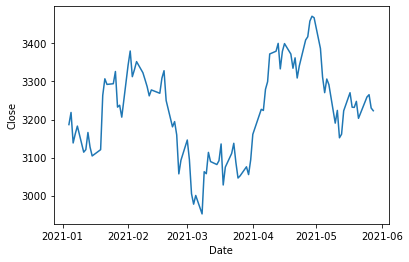

In [92]:
sns.lineplot(x="Date", y="Close", legend = 'full' , data=ticker_df['2021'])

<Figure size 432x288 with 0 Axes>

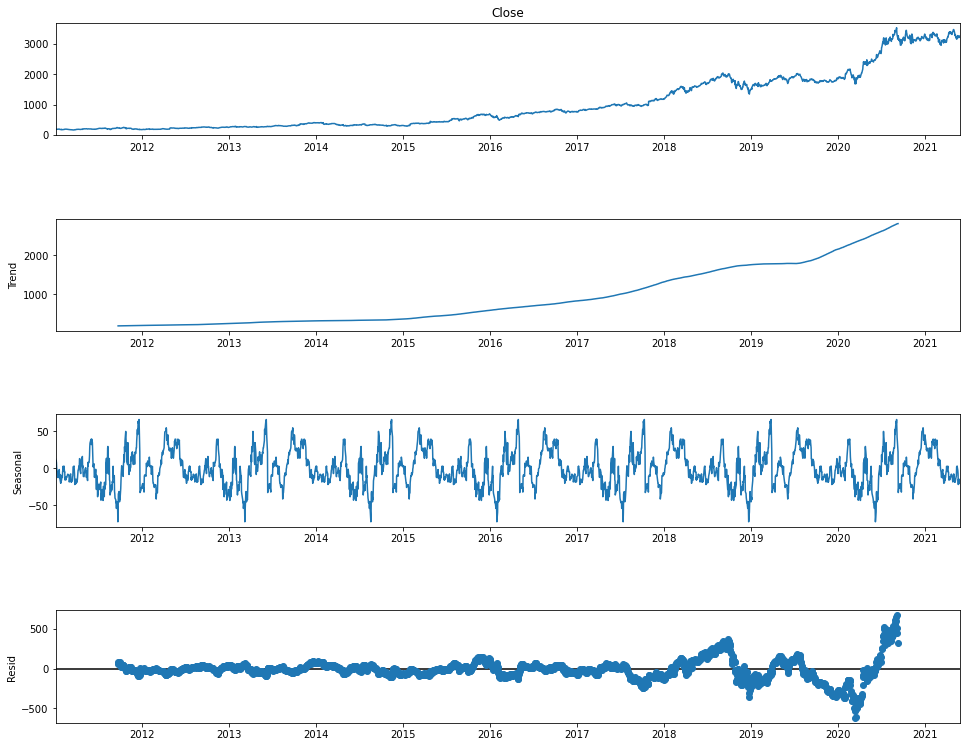

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ticker_df['Close'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

From the above graph, we observe an upwards trend. The above time series plot also suggests that the time series is not stationary and will require differencing to make it stationary.
A stationary time series is the one whose mean and variance are all constant over time. 

### Autocorrelation Function and Partial Autocorrelation Function Analysis

Autocorrelation 

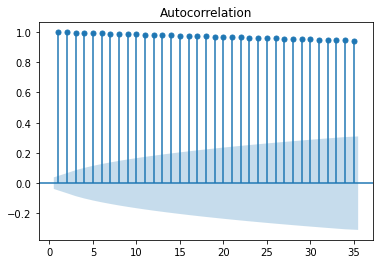

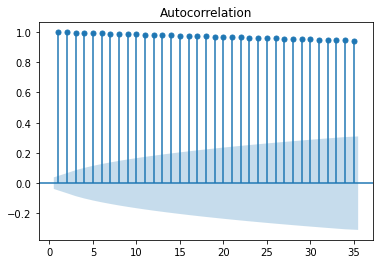

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the Settle Prices
plot_acf(ticker_df.Close, zero=False, lags=35)

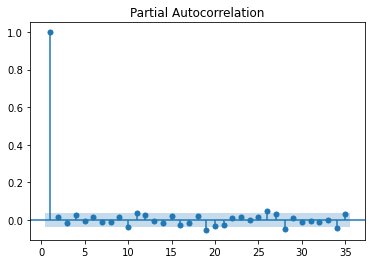

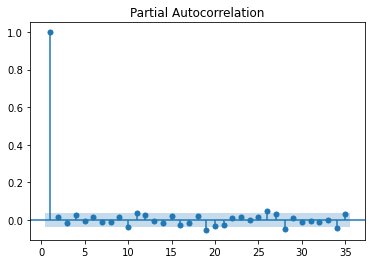

In [95]:
# Plot the partial autocorrelation 
plot_pacf(ticker_df.Close, zero=False, lags=35)

### Build the predictive ARIMA model

In [162]:
# Split the data set into a 70% for training and 30% for testing
split_data = int(len(ticker_df)*0.7)

train_data = ticker_df[0:split_data]
test_data = ticker_df[split_data:]

In [163]:
test_data.shape

(786, 6)

In [164]:
test_data.index

DatetimeIndex(['2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20',
               '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26',
               '2018-04-27', '2018-04-30',
               ...
               '2021-05-17', '2021-05-18', '2021-05-19', '2021-05-20',
               '2021-05-21', '2021-05-24', '2021-05-25', '2021-05-26',
               '2021-05-27', '2021-05-28'],
              dtype='datetime64[ns]', name='Date', length=786, freq=None)

In [165]:
test_data.shape

(786, 6)

In [158]:
# Get a numpy representation of a DataFrame(only the values in the 
# DataFrame will be returned, the axes labels will be removed.)
train_data_values = train_data['Close'].values
test_data_values = test_data['Close'].values

In [159]:
history = [t for t in train_data_values]
predictions = []
num_test_observation = len(test_data_values)

for test in range(num_test_observation):
    try:
        model = ARIMA(history, order=(1,1,1))
        # disp controls the frequency of the output during the iterations. 
        # disp < 0 means no output in this case.
        model_fit = model.fit(disp=0) 
        residuals = DataFrame(model_fit.resid)
        model_result = model_fit.forecast()
        results = model_result[0]
        predictions.append(results)
        true_test_value = test_data_values[test]
        history.append(true_test_value)
        print('predicted=%f, expected=%f' % (results, true_test_value))
    except:
        pass  
print(model_fit.summary())

if len(test_data_values)>len(predictions):
    MSE = mean_squared_error(test_data_values[:len(predictions)], predictions)
    RMSE = sqrt(MSE)    
else:
    MSE = mean_squared_error(test_data_values, predictions[:len(test_data_values)])
    RMSE = sqrt(MSE)
print(f'Test MSE and Test RMSE : {MSE} and {RMSE}')

# # # evaluate forecasts
# MSE = mean_squared_error(test_data_values, predictions)
# RMSE = sqrt(MSE)
# print('Testing Mean Squared Error is {}'.format(MSE))
# print('Testing Root Mean Squared Error is {}'.format(RMSE))

predicted=1442.051006, expected=1503.829956
predicted=1503.344619, expected=1527.839966
predicted=1527.783180, expected=1556.910034
predicted=1557.238983, expected=1527.489990
predicted=1528.012975, expected=1517.859985
predicted=1518.507490, expected=1460.089966
predicted=1461.280202, expected=1460.170044
predicted=1461.264459, expected=1517.959961
predicted=1518.161488, expected=1572.619995
predicted=1574.744832, expected=1566.130005
predicted=1565.553198, expected=1582.260010
predicted=1584.350825, expected=1569.680054
predicted=1570.154470, expected=1572.079956
predicted=1572.943215, expected=1580.949951
predicted=1580.636682, expected=1600.140015
predicted=1601.135364, expected=1592.390015
predicted=1592.972503, expected=1608.000000
predicted=1608.999070, expected=1609.079956
predicted=1609.788094, expected=1602.910034
predicted=1603.612462, expected=1601.540039
predicted=1602.298773, expected=1576.119995
predicted=1576.546020, expected=1587.280029
predicted=1588.246382, expected=

ValueError: x and y must have same first dimension, but have shapes (786,) and (26, 1)

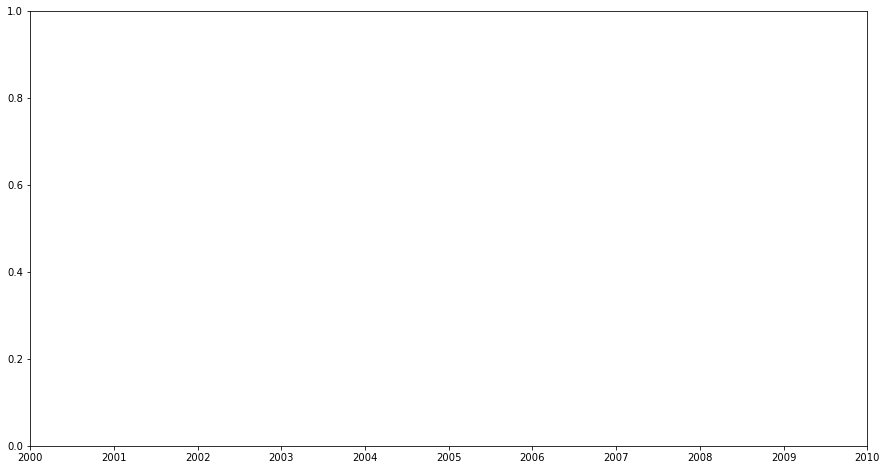

In [160]:
test_set_range = ticker_df[split_data:].index
plt.figure(figsize=(15, 8))
predicted_plot = plt.plot(test_set_range, predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
actual_plot = plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [166]:
results

array([1586.68715756])

In [161]:
test_set_range.shape

(786,)

In [155]:
test_data.shape

(786, 6)

In [11]:
ticker_df = ticker_df['Close'].values
split_data = int(len(ticker_df)*0.7)

train_data = ticker_df[0:split_data]
test_data = ticker_df[split_data:]
hsty = [x.astype(float) for x in train_data]
pred = []
for i in range(len(test_data)):
    try:
        model = ARIMA(hsty, order=(1,1,1))
        model_fit = model.fit(disp=0, start_ar_lags = None)
        residuals = DataFrame(model_fit.resid)
        out = model_fit.forecast()
        yhat = out[0]
        predictions.append(yhat)
        obs = test_data[i]
        hsty.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    except:
        pass
if len(test_data)>len(pred):
    err = mean_squared_error(test_data[:len(pred)], pred)
else:
    err = mean_squared_error(test_data, pred[:len(test_data)])
print(f'Test MSE : {err:.3f}')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.